In [1]:
# Repurposed SWRanalysis code to analyze powers for CA1 v. DG electrodes. Similar to
# Fig. 6 in Solomon NatComm 2018. Want to assess from range 50:300 Hz a la Sullivan et al 2011

In [112]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# sub lists I've been using to explore FR1 

# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus
# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1065J'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1048E','R1054J'] # nice example FR1 subs

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
37,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,0,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
38,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,1,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
639,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,0,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
640,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,1,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
641,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,2,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,2,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...


In [98]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                    ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df[404:413]
exp_df

# Makes most sense to take half the subjects 
if exp == 'FR1':
    np.random.seed(44462) # seed 44462 gives 25,845 of 60,417 recall trials (42.8%). Or 57/167 (34.1% of subs)
    from SWRmodule import total_sub_names_FR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_FR1)
    proportion_subs = 0.5 # it's really 0.5 of initial pre-localization.pairs subs. So comes out to numbers above. And what we want to match for catFR1
elif exp == 'catFR1':
    np.random.seed(44455) # seed 44455 gives 20,393 of 50,053 recall trials (40.7%). Or 47/136 (34.6% of subs)
    from SWRmodule import total_sub_names_catFR1 # all the unique sub names for FR1 task in df
    total_sub_names = copy(total_sub_names_catFR1)
    proportion_subs = 0.35 # 0.5
random_half_sub_names = np.random.permutation(np.unique(total_sub_names))[:int(np.floor(len(np.unique(total_sub_names))*proportion_subs))]
random_half_sub_names[:10] # just to see them
random_half_sub_names[-10:]
half_sub_idxs = np.array(findAinB(random_half_sub_names,exp_df.subject))
half_df = exp_df.iloc[half_sub_idxs]
half_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(554, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2149,NaN,protocols/r1/subjects/R1462M/experiments/FR1/s...,protocols/r1/subjects/R1462M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1462M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1462M/localizations/0/m...,NaN,0,R1462M,R1462M,3.4,protocols/r1/subjects/R1462M/experiments/FR1/s...
2151,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,0,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,0,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2152,NaN,protocols/r1/subjects/R1463E/experiments/FR1/s...,protocols/r1/subjects/R1463E/localizations/1/m...,FR1,build,1,protocols/r1/subjects/R1463E/experiments/FR1/s...,1,NaN,1,protocols/r1/subjects/R1463E/localizations/1/m...,NaN,1,R1463E,R1463E_1,3.4,protocols/r1/subjects/R1463E/experiments/FR1/s...
2166,NaN,protocols/r1/subjects/R1466J/experiments/FR1/s...,protocols/r1/subjects/R1466J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1466J/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1466J/localizations/0/m...,NaN,0,R1466J,R1466J,3.4,protocols/r1/subjects/R1466J/experiments/FR1/s...


array(['R1325C', 'R1310J', 'R1077T', 'R1288P', 'R1044J', 'R1108J',
       'R1002P', 'R1131M', 'R1316T', 'R1215M'], dtype='<U6')

array(['R1306E', 'R1137E', 'R1105E', 'R1048E', 'R1138T', 'R1122E',
       'R1094T', 'R1236J', 'R1120E', 'R1338T'], dtype='<U6')

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
83,NaN,protocols/r1/subjects/R1020J/experiments/FR1/s...,protocols/r1/subjects/R1020J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1020J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1020J/localizations/0/m...,NaN,0,R1020J,R1020J,NaN,protocols/r1/subjects/R1020J/experiments/FR1/s...
93,NaN,protocols/r1/subjects/R1022J/experiments/FR1/s...,protocols/r1/subjects/R1022J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1022J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1022J/localizations/0/m...,NaN,0,R1022J,R1022J,NaN,protocols/r1/subjects/R1022J/experiments/FR1/s...
126,NaN,protocols/r1/subjects/R1027J/experiments/FR1/s...,protocols/r1/subjects/R1027J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1027J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1027J/localizations/0/m...,NaN,0,R1027J,R1027J,1.0,protocols/r1/subjects/R1027J/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,0,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1743,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,1,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1744,NaN,protocols/r1/subjects/R1338T/experiments/FR1/s...,protocols/r1/subjects/R1338T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1338T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1338T/localizations/0/m...,NaN,2,R1338T,R1338T,3.1,protocols/r1/subjects/R1338T/experiments/FR1/s...
1757,NaN,protocols/r1/subjects/R1342M/experiments/FR1/s...,protocols/r1/subjects/R1342M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1342M/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1342M/localizations/0/m...,NaN,0,R1342M,R1342M,3.1,protocols/r1/subjects/R1342M/experiments/FR1/s...


In [99]:
## similar to Solomon NatComm Fig. 6A-B

def get_multitaper_power_with_freqs(eegs, time, freqs):
    # note: must be in ptsa format!!
    from ptsa.data.timeseries import TimeSeriesX
    import mne
    
    time_range = time # how long is eeg?
    arr = ptsa_to_mne(eegs,time_range)

    #Use MNE for multitaper power
    pows, fdone = mne.time_frequency.psd_multitaper(arr, fmin=freqs[0], fmax=freqs[-1], tmin=0.0,
                                                       verbose=False);
    # don't average over frequencies!!
    #pows = np.mean(np.log10(pows), 2) #will be shaped n_epochs, n_channels
    
    return pows,fdone # powers and freq. done

def get_multitaper_power(eegs, time, freqs):
    # note: must be in ptsa format!!
    from ptsa.data.timeseries import TimeSeriesX
    import mne   
    
    time_range = time # how long is eeg?
    arr = ptsa_to_mne(eegs,time_range)
    
    #Use MNE for multitaper power
    pows, fdone = mne.time_frequency.psd_multitaper(arr, fmin=freqs[0], fmax=freqs[-1], tmin=0.0,
                                                       verbose=False);

    pows = np.mean(np.log10(pows), 2) #will be shaped n_epochs, n_channels
    
    return pows,fdone # powers and freq. done

def get_tfr_multitaper_power(eegs, freqs, n_cycles, TBW, time_range):
    # input PTSA format
    from ptsa.data.timeseries import TimeSeriesX
    import mne
    
    # time_range is boundaries of eeg
    arr = ptsa_to_mne(eegs,time_range)
    
    # this multitaper program allows you to smooth via cycles at each frequency
    pows = mne.time_frequency.tfr_multitaper(arr, freqs=freqs, n_cycles=n_cycles,
                           time_bandwidth=TBW, return_itc=False, average=False)
    pows = np.mean(np.mean(np.log10(pows.data),2),2) # average across freqs and times to get n_epochs X chs
    return pows

## LOCAL run (original program)

In [ ]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

### PARAMS ###

fmin_pow = 5; fmax_pow = 250
eeg_start = -500
eeg_end = 0
baseline_correct = False
notch_filter = False

# # if using multitaper_tfr
# test_freqs = np.arange(fmin_pow,fmax_pow+0.1,5) # for get_tfr_multitaper_power
# n_cycles = np.floor(test_freqs/2)
# TBW = 2

save_values = 0

selected_period = 'surrounding_recall' # surrounding_recall # whole_retrieval # encoding 
# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 6 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels 

filter_type = 'hamming' # 'butter' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.

### END PARAMS ###

if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []

DG_pows = []; DG_baseline = []
CA1_pows = []; CA1_baseline = []
ENT_pows = []; ENT_baseline = []

for row in half_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 
        
        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
        good_recalls = selected_recalls_idxs & (nonrepeat_indicator>0) & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1)
        evs_free_recall = evs_free_recall[good_recalls]
        
        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
                
        # fix EEG offset due to Unity implementation error @@
#         init_time = eeg_events.iloc[0].eegoffset
        eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
#         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))

        eeg = reader.load_eeg(events = eeg_events, rel_start=eeg_start-1000, rel_stop=eeg_end,
                             clean=True, scheme=pairs)    
    
        eeg = eeg.to_ptsa()

        if baseline_correct == True:
            eeg = eeg.baseline_corrected((eeg_start,eeg_end))

        if notch_filter == True:
            from ptsa.data.filters import ButterworthFilter
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[118.,122.], filt_type='stop', order=4).filter()
            eeg = ButterworthFilter(timeseries=eeg, freq_range=[178.,182.], filt_type='stop', order=4).filter()
        else:
            pass   
        
        # Use MNE to get multitaper spectral power
        eeg_length = eeg_end-eeg_start+1000 # to get baseline 1 second earlier
        # linear frequencies
#         pows = get_tfr_multitaper_power(eeg, test_freqs, n_cycles, TBW, [eeg_buffer,eeg_length-eeg_buffer])
        #   this does log scale
        pows,freqs_done = get_multitaper_power_with_freqs(eeg, time=[1000,eeg_length],freqs = np.array([fmin_pow, fmax_pow]))
        pows_baseline,_ = get_multitaper_power_with_freqs(eeg, time=[0,eeg_end-eeg_start],freqs = np.array([fmin_pow, fmax_pow]))
        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []
            
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)

        region_electrode_ct = 0
        session_ripple_rate_by_elec = []
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # don't use bad electrodes                
               
                total_channel_ct+=1 # total channels before artifact removal
                
                if elec_regions[channel] in ['left dg','right dg','"dg"','dg']:
#                     DG_pows = superVstack(DG_pows,pows[:,channel])
                    DG_pows = superVstack(DG_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    DG_baseline = superVstack(DG_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])
                elif elec_regions[channel] in ['left ca1','right ca1','"ca1"','ca1']:
#                     CA1_pows = superVstack(CA1_pows,pows[:,channel])
                    CA1_pows = superVstack(CA1_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    CA1_baseline = superVstack(CA1_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])
                elif elec_regions[channel] in ENT_labels:
                    ENT_pows = superVstack(ENT_pows,np.mean(np.log10(pows[:, :, :]), 0)[channel])
                    ENT_baseline = superVstack(ENT_baseline,np.mean(np.log10(pows_baseline[:, :, :]), 0)[channel])

        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    if remove_soz_ictal == False:
        soz_label = 'soz_in'
    else:
        soz_label = 'soz_out'
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_channel_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords}, f)


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1002P/tal/R1002P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1002P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

2020-12-08_18-01-21: DF Exception: Sub: R1080E, Sess: 0, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 123 and the array at index 1 has size 122, file: <ipython-input-113-c38ec0ba4393>, line no: 236


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1080E/tal/R1080E_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1080E/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1080E/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

2020-12-08_18-01-25: DF Exception: Sub: R1080E, Sess: 1, ValueError, all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 123 and the array at index 1 has size 122, file: <ipython-input-113-c38ec0ba4393>, line no: 236


/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1083J/tal/R1083J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1083J/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1083J/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWa

DG electrodes: 174
CA1 electrodes: 312


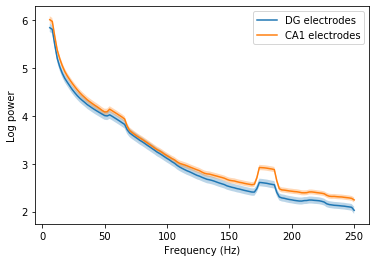

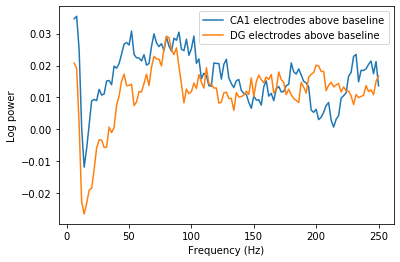

In [107]:
print('DG electrodes: '+str(DG_pows.shape[0]))
print('CA1 electrodes: '+str(CA1_pows.shape[0]))
print('Entorhinal electrodes: '+str(ENT_pows.shape[0]))

# DG
plot(freqs_done,np.mean(DG_pows,0))
DG_SE = np.std(DG_pows,0)/np.sqrt(DG_pows.shape[0])
fill_between(freqs_done, np.mean(DG_pows,0)-DG_SE, np.mean(DG_pows,0)+DG_SE, alpha = 0.3)

#CA1
plot(freqs_done,np.mean(CA1_pows,0))
CA1_SE = np.std(CA1_pows,0)/np.sqrt(CA1_pows.shape[0])
fill_between(freqs_done, np.mean(CA1_pows,0)-CA1_SE, np.mean(CA1_pows,0)+CA1_SE, alpha = 0.3)

# Entorhinal
plot(freqs_done,np.mean(ENT_pows,0))
ENT_SE = np.std(ENT_pows,0)/np.sqrt(ENT_pows.shape[0])
fill_between(freqs_done, np.mean(ENT_pows,0)-ENT_SE, np.mean(ENT_pows,0)+ENT_SE, alpha = 0.3)

# plot(freqs_done,np.mean(CA1_baseline,0))
# plot(freqs_done,np.mean(DG_baseline,0))
xlabel('Frequency (Hz)')
ylabel('Log power')
legend({'DG electrodes','CA1 electrodes'}) #,'CA1 baseline'})
show()

plot(freqs_done,np.mean(DG_pows,0)-np.mean(DG_baseline,0))
plot(freqs_done,np.mean(CA1_pows,0)-np.mean(CA1_baseline,0))
plot(freqs_done,np.mean(ENT_pows,0)-np.mean(ENT_baseline,0))
xlabel('Frequency (Hz)')
ylabel('Log power')
legend({'DG above baseline','CA1 above baseline','Entorhinal above baseline'});

## load LOCAL data if didn't just run above:

In [109]:
np.array(MTL_labels)
['left ec','right ec','entorhinal'

array(['left ca1', 'left ca2', 'left ca3', 'left dg', 'left sub',
       'left prc', 'left ec', 'left phc', 'left mtl wm', 'right ca1',
       'right ca2', 'right ca3', 'right dg', 'right sub', 'right prc',
       'right ec', 'right phc', 'right mtl wm', 'left amy', 'right amy',
       'parahippocampal', 'entorhinal', 'temporalpole', ' left amygdala',
       ' left ent entorhinal area', ' left hippocampus',
       ' left phg parahippocampal gyrus', ' left tmp temporal pole',
       ' right amygdala', ' right ent entorhinal area',
       ' right hippocampus', ' right phg parahippocampal gyrus',
       ' right tmp temporal pole', 'left amygdala',
       'left ent entorhinal area', 'left hippocampus',
       'left phg parahippocampal gyrus', 'left tmp temporal pole',
       'right amygdala', 'right ent entorhinal area', 'right hippocampus',
       'right phg parahippocampal gyrus', 'right tmp temporal pole',
       '"ba35"', '"ba36"', '"ca1"', '"dg"', '"erc"', '"phc"', '"sub"',
       'ba

In [12]:
%autoreload
# load params
# session_ct = 21; sub_num = 8; region_name = 'HPC' #'ENT' #'HPC_ENT' #'HPC'
session_ct = 13; sub_num = 6; region_name='HPC' # load for initial 6 HPC test subs
# session_ct = 9; sub_num = 5; region_name = 'ENT'; # 5 initial subjects with ERC regions
# session_ct = 1; sub_num = 1; filter_type = 'hamming'; sub = 'R1010J' # sub='R1112M'
# session_ct = 5; sub_num = 2; filter_type = 'hamming' # ['R1010J','R1112M'] initial 2
remove_soz_ictal = False
selected_period = 'surrounding_recall'
recall_selection_name = ''

recall_selection_name = ''
if recall_type_switch == 1:
    recall_selection_name = 'FIRSTOFCOMPOUND'
elif recall_type_switch == 2:
    recall_selection_name = 'RECALLTWO'
elif recall_type_switch == 3:
    recall_selection_name = 'SOLONOCOMPOUND'

if remove_soz_ictal == False:
    soz_label = 'soz_in'
elif remove_soz_ictal == True:
    soz_label = 'soz_out'
else:
    soz_label = ''

fn = os.path.join('/home1/john/SWR/compiled/',
        'SWR_'+region_name+'_'+str(session_ct)+'_sessions_'+str(sub_num)+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            

with open(fn,'rb') as f:
    dat = pickle.load(f)
    ripple_array = dat['ripple_array']; session_ct = dat['session_ct']
    HPC_names = dat['HPC_names']; sub_sess_names = dat['sub_sess_names']
    channel_ct = dat['channel_ct']; #ripple_array2 = dat['ripple_array2']
    trial_nums = dat['trial_nums']; #trial_nums2 = dat['trial_nums2']
    fr_array = dat['fr_array']; sub_names = dat['sub_names']; encoded_word_key_array = dat['encoded_word_key_array']
    total_recalls = dat['total_recalls']; kept_recalls = dat['kept_recalls']
    trial_by_trial_correlation = dat['trial_by_trial_correlation']; elec_ripple_rate_array = dat['elec_ripple_rate_array']
    

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 7., 3., 0., 0., 1., 0., 0., 0.,
        0., 0.]),
 array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
        -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
        -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
         2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
         6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02]),
 <a list of 19 Patch objects>)

Text(0.5, 0, 'Trial by trial correlation')

Text(0, 0.5, 'Electrode count')

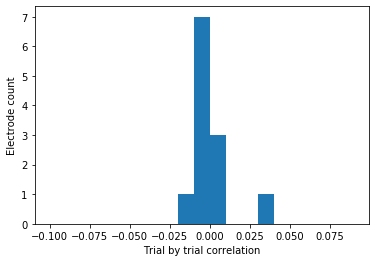

(array([0., 0., 0., 0., 0., 0., 3., 2., 2., 1., 0., 1., 0., 1., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95]),
 <a list of 39 Patch objects>)

Text(0.5, 0, 'Ripple rate (hz)')

Text(0, 0.5, 'Electrode count')

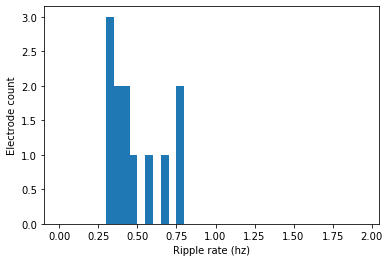

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([-3.50000000e-01, -3.25000000e-01, -3.00000000e-01, -2.75000000e-01,
        -2.50000000e-01, -2.25000000e-01, -2.00000000e-01, -1.75000000e-01,
        -1.50000000e-01, -1.25000000e-01, -1.00000000e-01, -7.50000000e-02,
        -5.00000000e-02, -2.50000000e-02,  3.33066907e-16,  2.50000000e-02,
         5.00000000e-02,  7.50000000e-02,  1.00000000e-01,  1.25000000e-01,
         1.50000000e-01,  1.75000000e-01,  2.00000000e-01,  2.25000000e-01,
         2.50000000e-01,  2.75000000e-01,  3.00000000e-01,  3.25000000e-01]),
 <a list of 27 Patch objects>)

Text(0.5, 0, 'Elec by elec correlation')

Text(0, 0.5, 'Electrode count')

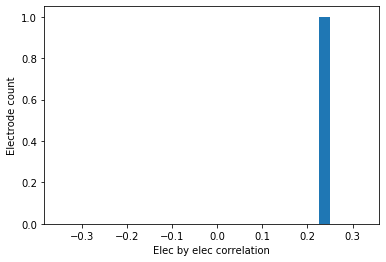

In [710]:
# to visualize the removal parameters

# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01)); xlabel('Trial by trial correlation'); ylabel('Electrode count'); show()
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05)); xlabel('Ripple rate (hz)'); ylabel('Electrode count'); show()
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025)); xlabel('Elec by elec correlation'); ylabel('Electrode count'); show()

## Get start_array and select subfield if HPC for free recalls

In [646]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number
select_greater_than_rectime = 0          # select only recalls > this number
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions

# select for subfield if HPC
if select_subfield == True:
    location_selected = ['dg','ca1'] #['dg','ca1'] #'dg' # 'ca3' # 'dg' 'ca1' # sub 
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<=select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

location_mask = location_mask[temp_recall_idxs] # gotta translate this to new frame as well from idxs in load step

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis

    
print('Got start_array with '+str(start_array.shape[0])+' trials!')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 538
from 115 sessions from 57 subjects with trial nums:
[78. 78. 78. 78. 78. 51. 51. 51. 51. 51. 69. 69. 69. 69. 69. 69. 45. 45.
 45. 19.]
Trial sum = 25787.0
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'right ca1', 'right dg', 'right dg', 'right sub', 'right sub', 'right ca1', 'left sub', 'left dg', 'left ca1', 'left ca1']
Number of sub_sess names: 538
Got start_array with 12437 trials!
